# Detection With LSTM 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string 

from bs4 import BeautifulSoup
from nltk.corpus import stopwords  

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from keras.preprocessing import text,sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout

import warnings
warnings.filterwarnings('ignore')

In [2]:
real_news = pd.read_csv('True_News.csv')
fake_news = pd.read_csv('Fake_News.csv')



In [15]:
real_news.shape,fake_news.shape

((21417, 5), (23481, 5))

In [3]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
real_news['target'] = 0
fake_news['target'] = 1

In [6]:
data = pd.concat([real_news, fake_news], ignore_index=True, sort=False)
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [7]:
data.isnull().sum()


title      0
text       0
subject    0
date       0
target     0
dtype: int64

### Visualization

1    23481
0    21417
Name: target, dtype: int64


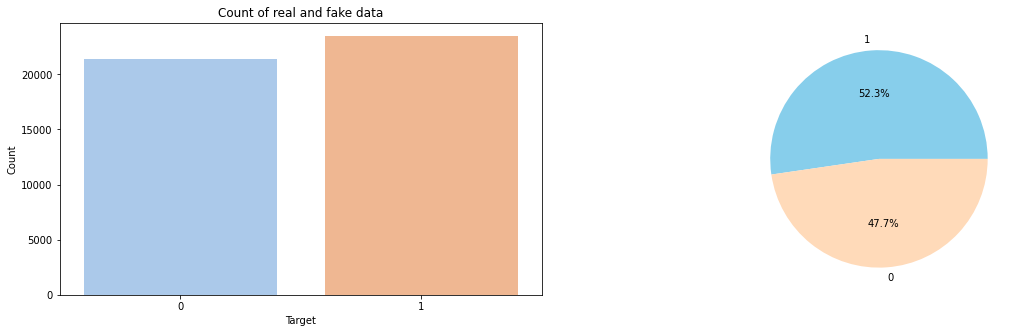

In [8]:
print(data["target"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(data.target,ax=ax[0],palette="pastel");
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("Target")
g2 = plt.pie(data["target"].value_counts().values,explode=[0,0],labels=data.target.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

Balanced Data

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

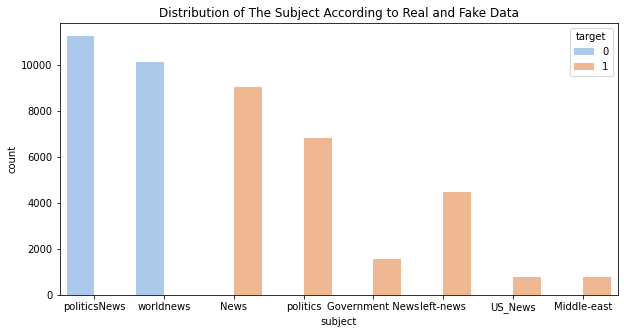

In [9]:
print(data.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='target', data=data, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

### Cleaning

In [10]:
data['text']= data['subject'] + " " + data['title'] + " " + data['text']
del data['title']
del data['subject']
del data['date']
data.head()

,text,target
0,"politicsNews As U.S. budget fight looms, Repub...",0
1,politicsNews U.S. military to accept transgend...,0
2,politicsNews Senior U.S. Republican senator: '...,0
3,politicsNews FBI Russia probe helped by Austra...,0
4,politicsNews Trump wants Postal Service to cha...,0


In [19]:
data.shape

(44898, 2)

In [12]:
first_text = data.text[0]
first_text

'politicsNews As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional incr

In [22]:
#Removal of HTML Contents
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removal of Punctuation Marks
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

# Removal of Special Characters
def remove_characters(text):
    return re.sub("[^a-zA-Z]"," ",text)

#Removal of stopwords 
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)

#Total function
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

#Apply function on text column
data['text']=data['text'].apply(cleaning)

In [25]:
data.head()

,text,target
0,politicsnews u budget fight loom republican fl...,0
1,politicsnews u military accept transgender rec...,0
2,politicsnews senior u republican senator let m...,0
3,politicsnews fbi russia probe helped australia...,0
4,politicsnews trump want postal service charge ...,0


### Word Clouds

##### 1. Real News

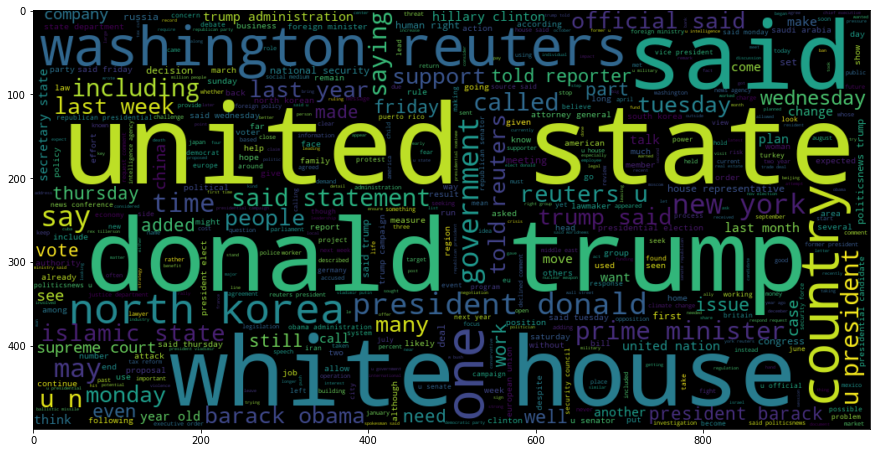

In [26]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

##### 2. Fake News

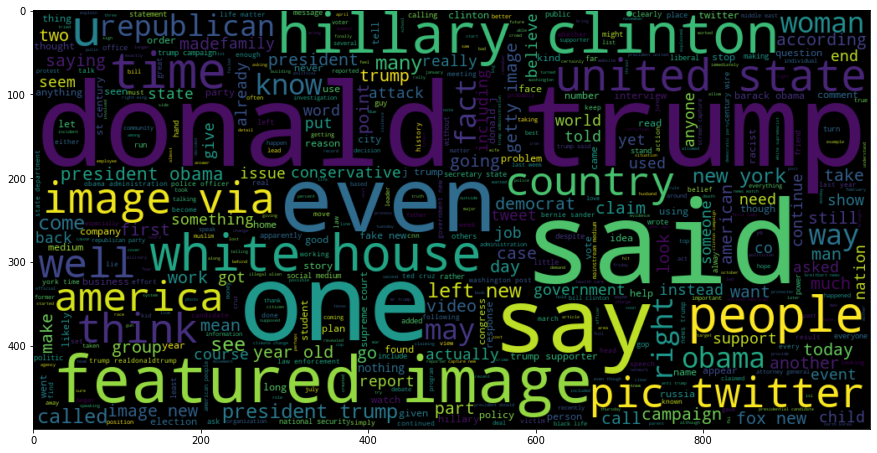

In [27]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

### N gram Analysis

In [28]:
texts = ' '.join(data['text'])

string = texts.split(" ")

def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

           word   count
0      (trump,)  149603
1       (said,)  133030
2          (u,)   78516
3      (state,)   62726
4  (president,)   58790


<AxesSubplot:xlabel='count', ylabel='word'>

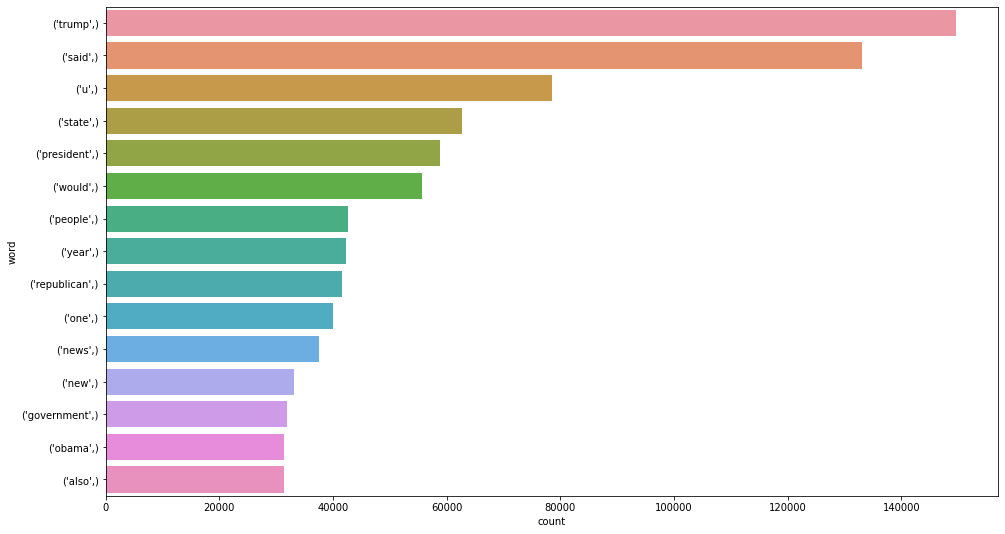

In [29]:
draw_n_gram(string,1) #unigram

                 word  count
0     (donald, trump)  25203
1     (united, state)  18943
2      (white, house)  16296
3  (hillary, clinton)  10217
4         (new, york)   9305


<AxesSubplot:xlabel='count', ylabel='word'>

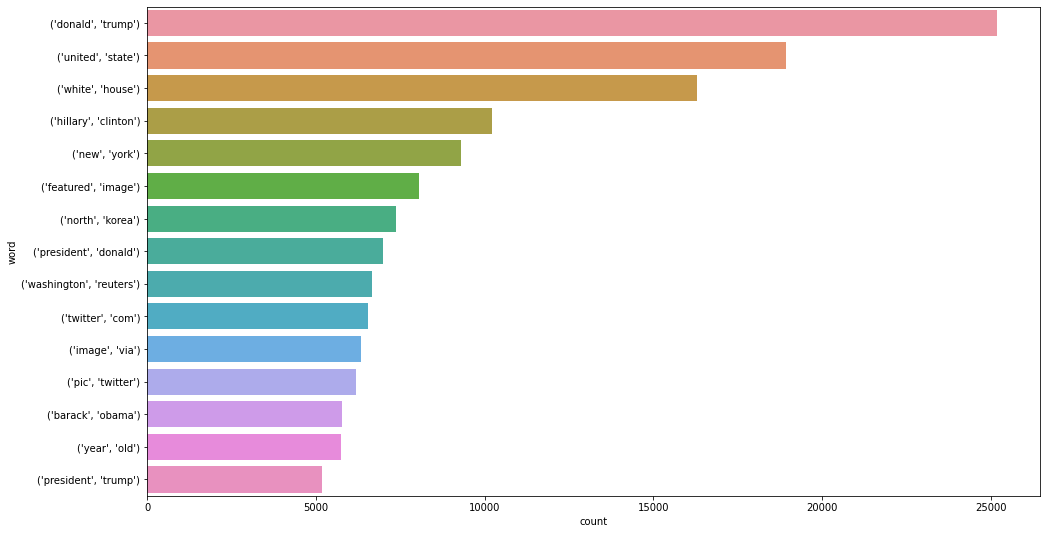

In [30]:
draw_n_gram(string,2) #bigram

                         word  count
0  (president, donald, trump)   6830
1         (pic, twitter, com)   6185
2      (featured, image, via)   6029
3  (president, barack, obama)   3911
4        (getty, image, news)   3575


<AxesSubplot:xlabel='count', ylabel='word'>

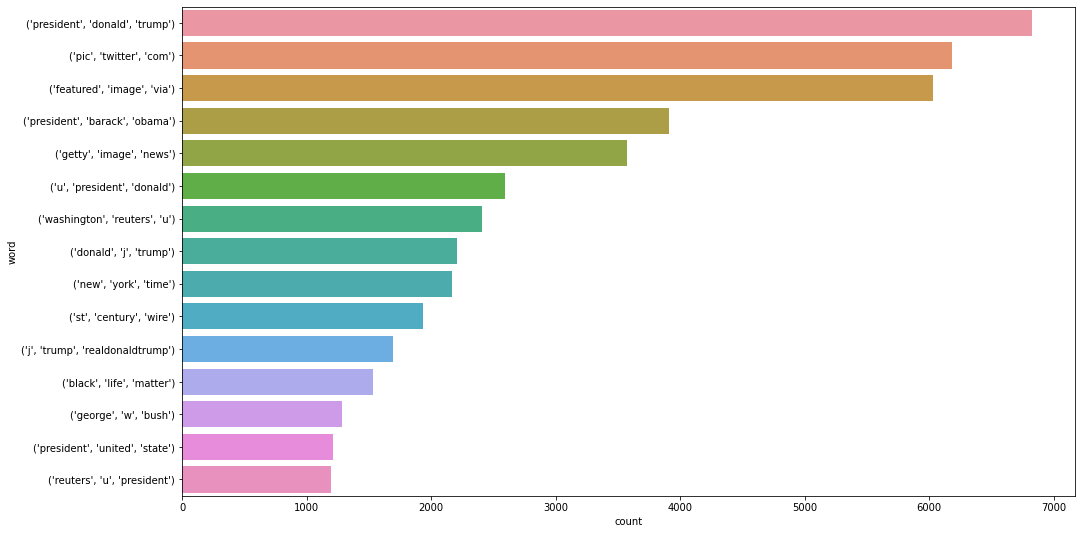

In [31]:
draw_n_gram(string,3) #tri gram

## Model

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], random_state=0)

In [34]:
max_features = 10000
maxlen = 300 #length of news to 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [35]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

### LSTM

In [45]:
batch_size = 256
embed_size = 100

In [46]:
model = Sequential()
#embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 300, 128)          117248    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [48]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=5, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/5
93/93 [==============================] - 729s 8s/step - loss: 0.5404 - accuracy: 0.7128 - val_loss: 0.3128 - val_accuracy: 0.8602
Epoch 2/5
93/93 [==============================] - 726s 8s/step - loss: 0.3438 - accuracy: 0.8442 - val_loss: 0.3304 - val_accuracy: 0.8456
Epoch 3/5
93/93 [==============================] - 721s 8s/step - loss: 0.2925 - accuracy: 0.8724 - val_loss: 0.2921 - val_accuracy: 0.8822
Epoch 4/5
93/93 [==============================] - 744s 8s/step - loss: 0.2520 - accuracy: 0.8968 - val_loss: 0.2760 - val_accuracy: 0.9001
Epoch 5/5
93/93 [==============================] - 784s 8s/step - loss: 0.2389 - accuracy: 0.9066 - val_loss: 0.5288 - val_accuracy: 0.7755


In [49]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 165s 156ms/step - loss: 0.5263 - accuracy: 0.7827
Accuracy of the model on Training Data is -  78.27339172363281 %
351/351 [==============================] - 42s 119ms/step - loss: 0.5256 - accuracy: 0.7802
Accuracy of the model on Testing Data is -  78.02227139472961 %


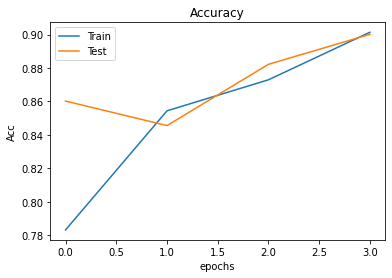

In [53]:
plt.figure()
plt.plot(history.history["accuracy"][0:4], label = "Train")
plt.plot(history.history["val_accuracy"][0:4], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

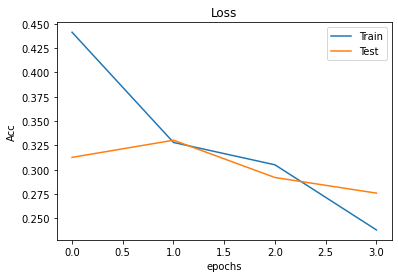

In [54]:
plt.figure()
plt.plot(history.history["loss"][0:4], label = "Train")
plt.plot(history.history["val_loss"][0:4], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [52]:
pred = model.predict_classes(X_test)
print(classification_report(y_test, pred, target_names = ['Fake','Real']))

              precision    recall  f1-score   support

        Fake       0.69      0.98      0.81      5367
        Real       0.97      0.60      0.74      5858

    accuracy                           0.78     11225
   macro avg       0.83      0.79      0.77     11225
weighted avg       0.84      0.78      0.77     11225



# Detection With GloVe

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [2]:
true = pd.read_csv("True_News.csv")
false = pd.read_csv("Fake_News.csv")

In [3]:
true['category'] = 0
false['category'] =1

In [4]:
df = pd.concat([true,false])

In [5]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [6]:
df.shape

(44898, 5)

In [7]:
df.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [9]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [10]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [11]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

c:\users\divya\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\divya\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\divya\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\divya\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use ei

Text(0.5, 0.98, 'Average word length in each text')

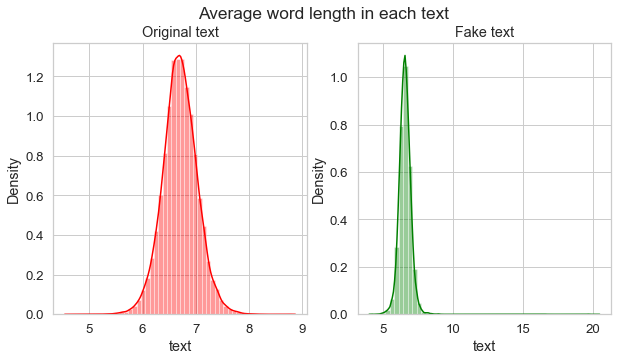

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['category']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Original text')
word=df[df['category']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

In [16]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text)
corpus[:5]

['WASHINGTON', '(Reuters)', 'head', 'conservative', 'Republican']

In [17]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common #most common words

{'Trump': 111503,
 'said': 93162,
 'would': 54613,
 'U.S.': 50441,
 'President': 33180,
 'people': 33115,
 'also': 30325,
 'one': 29370,
 'Donald': 27795,
 'said.': 26194}

In [18]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [19]:
max_features = 10000
maxlen = 300

In [20]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [21]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [22]:
EMBEDDING_FILE = 'glove_twitter.27B.100d.txt' #pre trained embedding file

In [24]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE,encoding="utf8"))

In [25]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

c:\users\divya\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3347: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [26]:
batch_size = 256
embed_size = 100

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [28]:
#Defining Neural Network
model = Sequential()
#embedding layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 6 , callbacks = [learning_rate_reduction])

Epoch 1/6
132/132 [==============================] - 759s 6s/step - loss: 0.3200 - accuracy: 0.8658 - val_loss: 0.0202 - val_accuracy: 0.9946
Epoch 2/6
132/132 [==============================] - 927s 7s/step - loss: 0.0204 - accuracy: 0.9941 - val_loss: 0.0280 - val_accuracy: 0.9910
Epoch 3/6
132/132 [==============================] - 1044s 8s/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.0428 - val_accuracy: 0.9858

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/6
132/132 [==============================] - 1030s 8s/step - loss: 0.0149 - accuracy: 0.9955 - val_loss: 0.0072 - val_accuracy: 0.9986
Epoch 5/6
132/132 [==============================] - 1040s 8s/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.0131 - val_accuracy: 0.9962
Epoch 6/6
132/132 [==============================] - 1062s 8s/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0100 - val_accuracy: 0.9979

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0024

In [30]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 [==============================] - 131s 124ms/step - loss: 0.0012 - accuracy: 0.9995
Accuracy of the model on Training Data is -  99.94654655456543 %
351/351 [==============================] - 46s 130ms/step - loss: 0.0100 - accuracy: 0.9979
Accuracy of the model on Testing Data is -  99.7861921787262 %


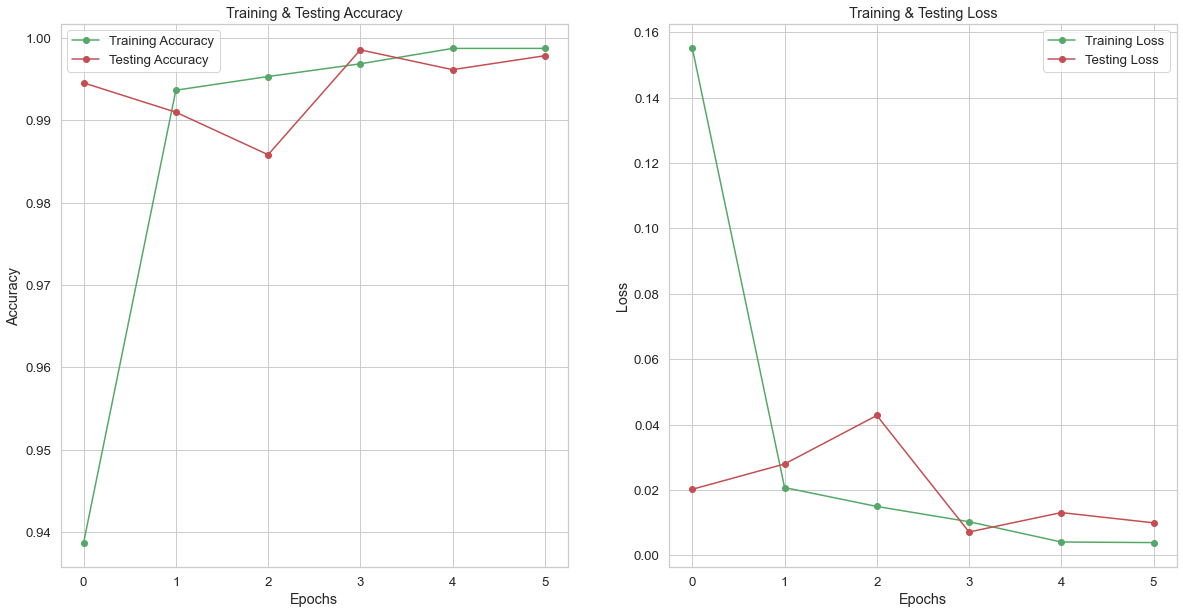

In [32]:
epochs = [i for i in range(6)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [46]:
pred=(model.predict(X_test)>0.5).astype('int32')

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [49]:
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Original','Fake'] , columns = ['Original','Fake'])

Text(64.5, 0.5, 'Actual')

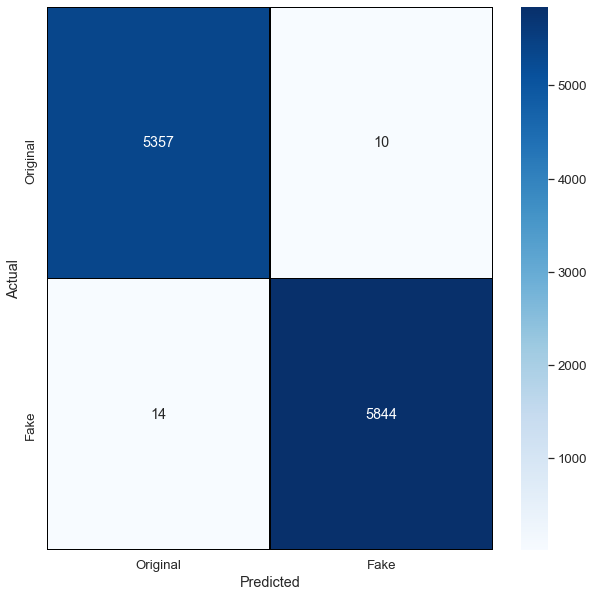

In [50]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Original','Fake'] , yticklabels = ['Original','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

## References

#### 1. Ilaydadu, Fake news detection with LSTM, Kaggle
#### 2.  Fake news detection with GloVe embeddings, Kaggle